<a href="https://www.kaggle.com/code/jlcordoba/birdclef-notebook-pplu?scriptVersionId=92380864" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import json
import librosa
import librosa.display
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
#reading CSV with pandas
Taxonomy = pd.read_csv('../input/birdclef-2022/eBird_Taxonomy_v2021.csv')
test = pd.read_csv('../input/birdclef-2022/test.csv')
train_metadata = pd.read_csv('../input/birdclef-2022/train_metadata.csv')
submission = pd.read_csv('../input/birdclef-2022/sample_submission.csv')
from os import path
from pydub import AudioSegment
import seaborn as sns

# files
src = "../input/birdclef-2022/train_audio/afrsil1/XC395771.ogg"#this audio have 4.5 rating
dst = "/kaggle/working/XC395771.wav"

# convert ogg to wav
sound = AudioSegment.from_ogg(src)
sound.export(dst, format="wav")

#transform into dataframe
df_taxonomy = pd.DataFrame(Taxonomy)

df_test = pd.DataFrame(test)

df_train = pd.DataFrame(train_metadata)

df_submission = pd.DataFrame(submission)

df_taxonomy.head()







# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
    #for filename in filenames:
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

,TAXON_ORDER,CATEGORY,SPECIES_CODE,PRIMARY_COM_NAME,SCI_NAME,ORDER1,FAMILY,SPECIES_GROUP,REPORT_AS
0,1,species,ostric2,Common Ostrich,Struthio camelus,Struthioniformes,Struthionidae (Ostriches),Ostriches,NaN
1,6,species,ostric3,Somali Ostrich,Struthio molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
2,7,slash,y00934,Common/Somali Ostrich,Struthio camelus/molybdophanes,Struthioniformes,Struthionidae (Ostriches),NaN,NaN
3,8,species,grerhe1,Greater Rhea,Rhea americana,Rheiformes,Rheidae (Rheas),Rheas,NaN
4,14,species,lesrhe2,Lesser Rhea,Rhea pennata,Rheiformes,Rheidae (Rheas),NaN,NaN


In [2]:
df_test.head()

,row_id,file_id,bird,end_time
0,soundscape_1000170626_akiapo_5,soundscape_1000170626,akiapo,5
1,soundscape_1000170626_akiapo_10,soundscape_1000170626,akiapo,10
2,soundscape_1000170626_akiapo_15,soundscape_1000170626,akiapo,15


In [3]:
df_train.size

193076

In [4]:
df_train['primary_label']

0        afrsil1
1        afrsil1
2        afrsil1
3        afrsil1
4        afrsil1
          ...   
14847     zebdov
14848     zebdov
14849     zebdov
14850     zebdov
14851     zebdov
Name: primary_label, Length: 14852, dtype: object

In [5]:
df_train.columns
df_train.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [6]:
df_train['filename'][16]

'akekee/XC174953.ogg'

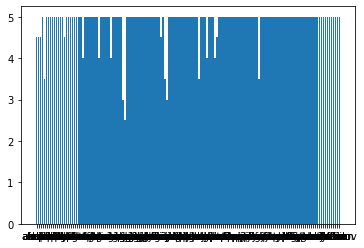

In [7]:
df_train['rating']
y_axis = df_train['rating']
x_axis = df_train['primary_label']
plt.bar(x_axis, y_axis)
plt.show()

In [8]:
df_submission.head()

,row_id,target
0,soundscape_1000170626_akiapo_5,False
1,soundscape_1000170626_akiapo_10,False
2,soundscape_1000170626_akiapo_15,False


In [9]:
#opening the socred bird file
with open('../input/birdclef-2022/scored_birds.json','r') as f:
    data = json.load(f)

In [10]:
print(data)

['akiapo', 'aniani', 'apapan', 'barpet', 'crehon', 'elepai', 'ercfra', 'hawama', 'hawcre', 'hawgoo', 'hawhaw', 'hawpet1', 'houfin', 'iiwi', 'jabwar', 'maupar', 'omao', 'puaioh', 'skylar', 'warwhe1', 'yefcan']


In [11]:
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')


In [12]:
len(samples)

871744

In [13]:
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)

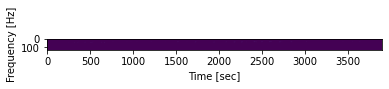

In [14]:
plt.pcolormesh(times, frequencies, spectrogram)
plt.imshow(spectrogram)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

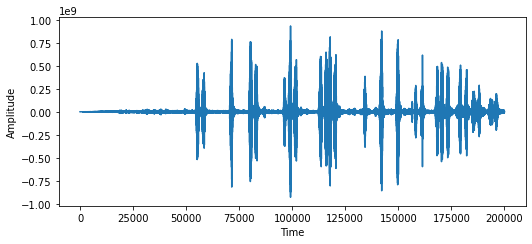

In [15]:
#Plotting Amplitude of a wav file against time
from scipy.io.wavfile import read
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
input_data = read("/kaggle/working/XC395771.wav")
audio = input_data[1]
plt.plot(audio[0:200000])#6seconds of video
plt.ylabel("Amplitude")
plt.xlabel("Time")
plt.show()

hypothesis: we need to consider the distancies between peaks with aproximately the same amplitude but only the ones which are close to each other, for example, the first two peaks that can be seeing in the image above. I think one of the features can be the average speed at which the bird repeat the same frequency. It is easier to understand when you listen the first 6 second of the audio and see the image above at the same time.

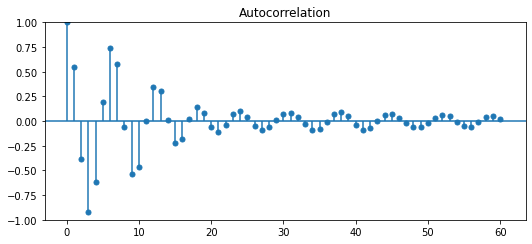

In [16]:
#Lets try to look for periodicity in this audio

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(audio)
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

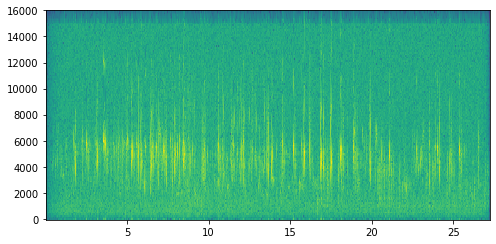

<Figure size 216x216 with 0 Axes>

In [17]:
#Creating an spectrogram of the same file
import matplotlib.pyplot as plt
from scipy import signal
from scipy.io import wavfile
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
sample_rate, samples = wavfile.read('/kaggle/working/XC395771.wav')
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
plt.pcolormesh(times, frequencies, 10 * np.log10(spectrogram),shading = 'auto')
plt.figure(figsize = (3,3))

plt.show

In [18]:
#We calculate the discrete Fourier Transformation for our signal

fft_spectrum = np.fft.rfft(input_data[1])

In [19]:
fft_spectrum

array([ 14081006.               +0.j        ,
       -55112870.46310902+14860739.43745732j,
        -9218550.8361727  -8984545.7499299j , ...,
        -2780734.48171294  -372362.47420359j,
        -4229068.03072262   -24731.78713393j,
         2652726.               +0.j        ])

In [20]:
#range of frequencies
freq = np.fft.rfftfreq(input_data[1].size, d = 1./sample_rate)

In [21]:
fft_spectrum_abs = np.abs(fft_spectrum)

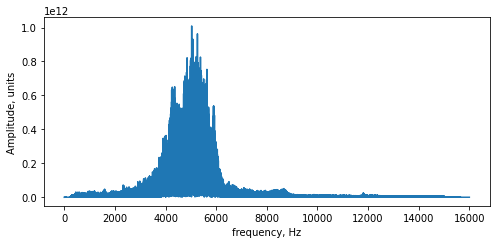

In [22]:
# we plot FFT
plt.plot(freq,fft_spectrum_abs)
plt.xlabel("frequency, Hz")
plt.ylabel("Amplitude, units")
plt.show()

Hypothesis:  We may fit a gaussian here and get sigma values. Depending on the bird we may fit more than one gaussian and get more than one sigma value.

In [23]:
np.shape(spectrogram)

(129, 3891)

In [24]:
len(frequencies)

129

In [25]:
len(times)

3891

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


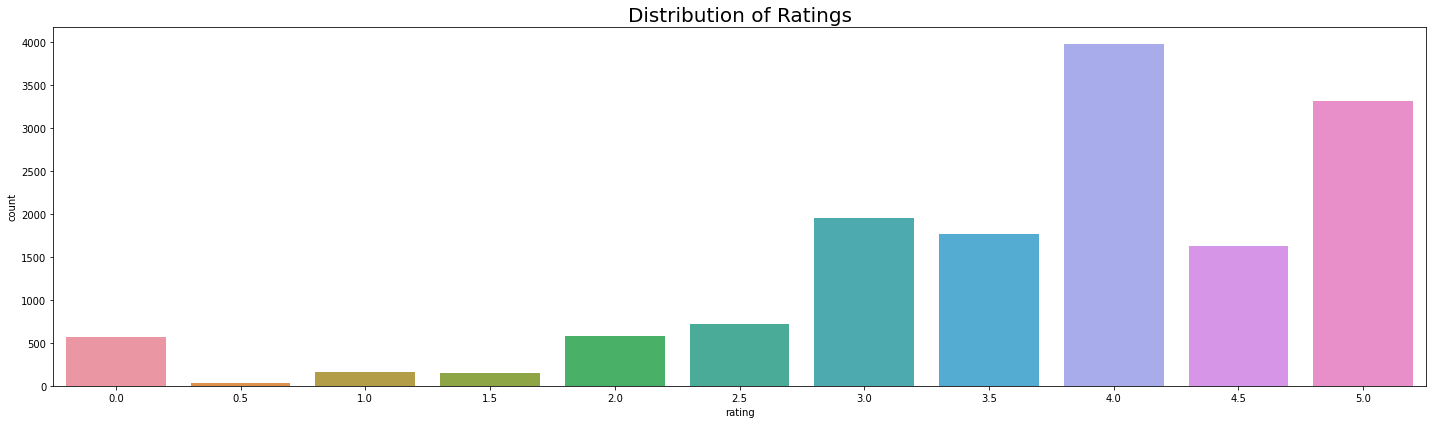

In [26]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


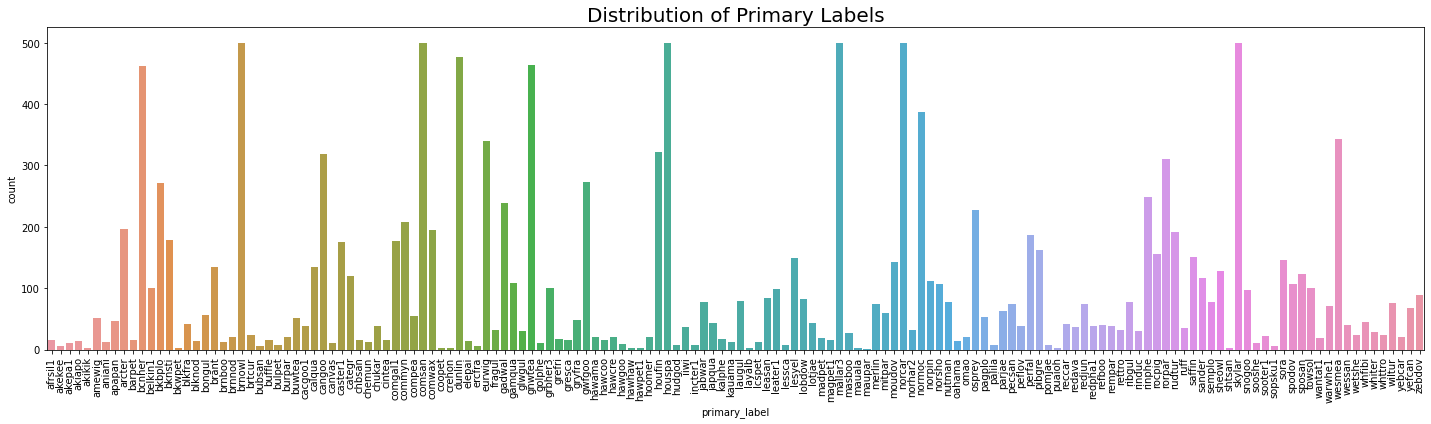

In [27]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['primary_label'])
plt.xticks(rotation=90)
plt.title("Distribution of Primary Labels", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


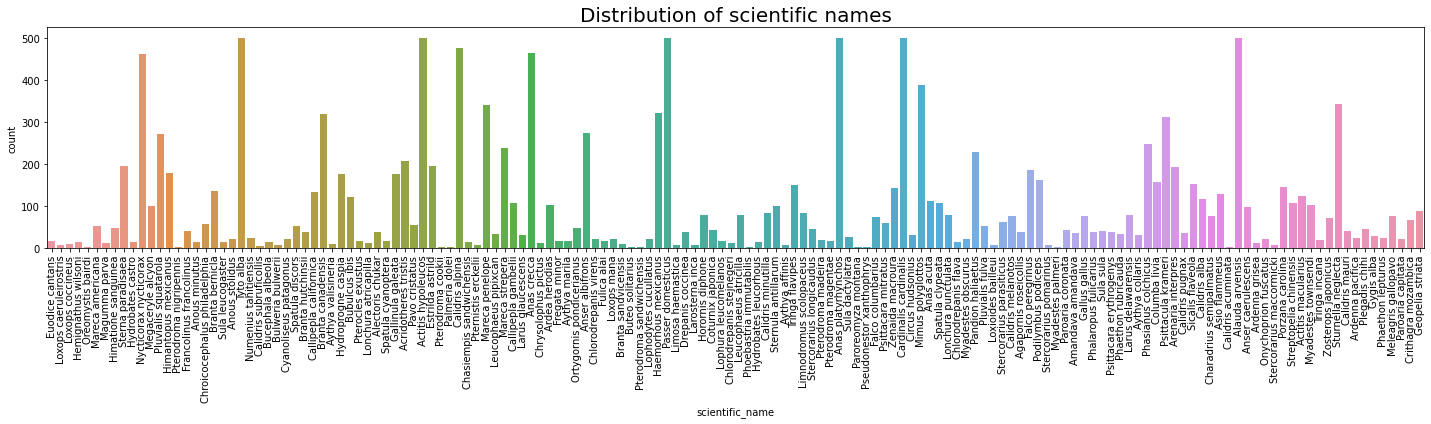

In [28]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['scientific_name'])
plt.xticks(rotation=90)
plt.title("Distribution of scientific names", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/IPython/core/pylabtools.py:151: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.canvas.print_figure(bytes_io, **kw)


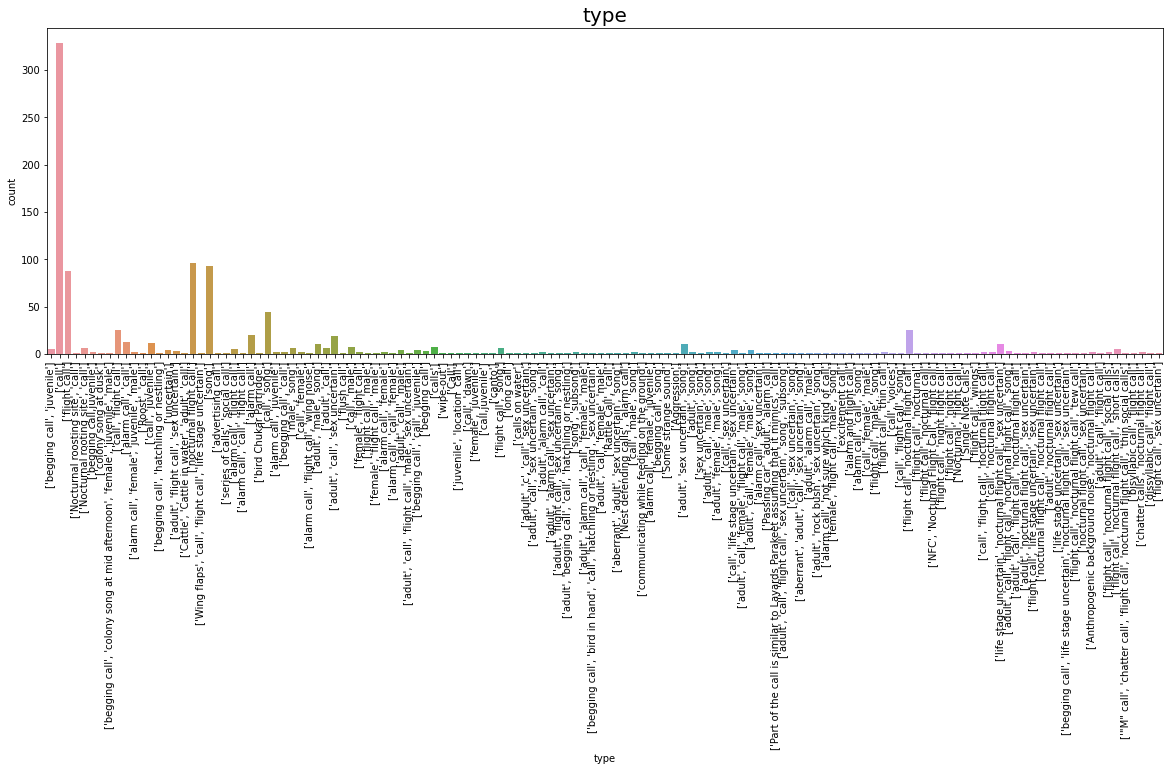

In [29]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'][3000:4000])
plt.xticks(rotation=90)
plt.title("type", fontsize=20)

plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


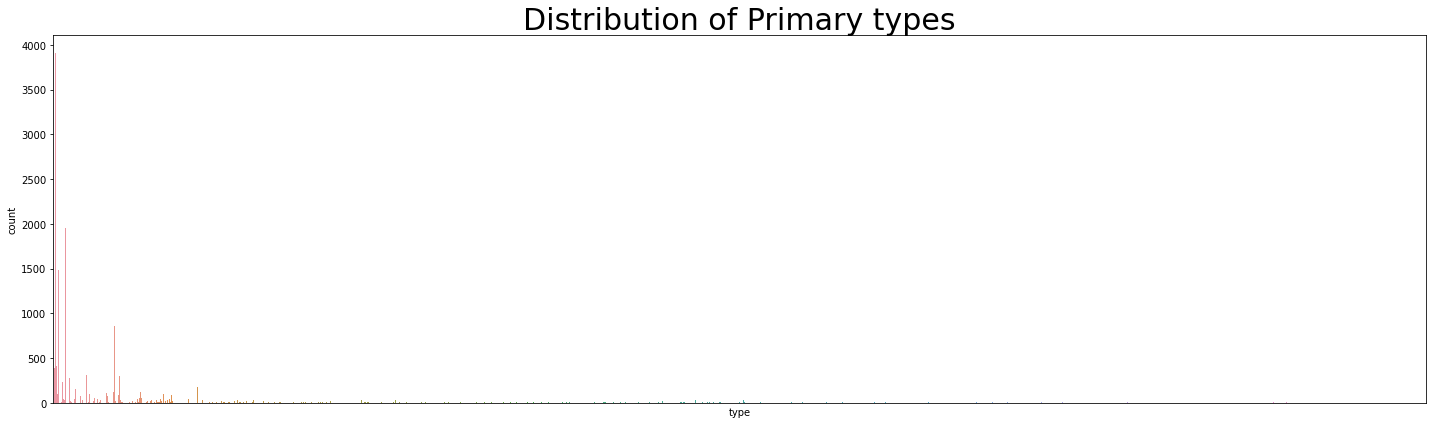

In [30]:
plt.figure(figsize=(20, 6))

sns.countplot(df_train['type'])
plt.title("Distribution of Primary types", fontsize=30)
plt.tick_params(axis = 'x', which = 'both', bottom = False,top = False, labelbottom = False )
plt.show()

In [31]:
#Elimino los elementos con un rating menor que 2.5, 
#lo que elimina tb los elementos que no tienen rating
for i in df_train.index:
    if df_train['rating'][i]<2.5:
        df_train.drop([i],axis = 0, inplace = True)


In [32]:
df_train['rating'][0:5]
df_train

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
...,...,...,...,...,...,...,...,...,...,...,...,...,...
14847,zebdov,[],"['adult', 'song']",22.6499,120.2872,Geopelia striata,Zebra Dove,Jerome Chie-Jen Ko,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:36,https://www.xeno-canto.org/629769,zebdov/XC629769.ogg
14848,zebdov,[],"['adult', 'sex uncertain', 'song']",1.4168,103.7287,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,08:00,https://www.xeno-canto.org/642415,zebdov/XC642415.ogg
14849,zebdov,[],"['adult', 'call', 'sex uncertain']",1.4347,103.7043,Geopelia striata,Zebra Dove,Kim Chuah Lim,Creative Commons Attribution-NonCommercial-Sha...,4.0,09:00,https://www.xeno-canto.org/665873,zebdov/XC665873.ogg
14850,zebdov,[],['song'],3.3508,101.2451,Geopelia striata,Zebra Dove,Jelle Scharringa,Creative Commons Attribution-NonCommercial-Sha...,2.5,11:15,https://www.xeno-canto.org/666194,zebdov/XC666194.ogg


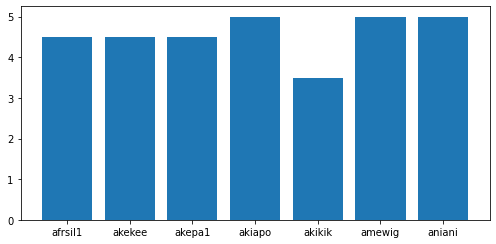

In [33]:
#histogram for some specie rating
df_train['rating']
y_axis = df_train['rating'][0:100]
x_axis = df_train['primary_label'][0:100]
plt.bar(x_axis, y_axis)
plt.show()

In [34]:
np.arange(16)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

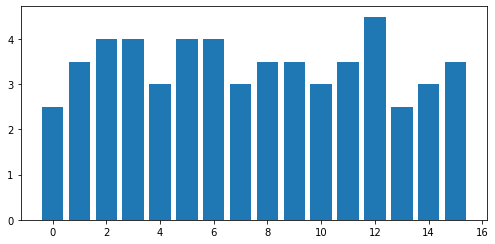

In [35]:
#rating for afrsil1, 16 audio elements
y_axis = df_train['rating'][0:16]
x_axis = np.arange(0,16)
plt.bar(x_axis, y_axis)
plt.show()

In [36]:
audio.size

871744

In [37]:
input_data

(32000,
 array([ 13198, -11842, -57367, ..., -12302,  -3385,  -7392], dtype=int32))

In [38]:
df_train.head(20)

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg
5,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,16:30,https://www.xeno-canto.org/207432,afrsil1/XC207432.ogg
6,afrsil1,[],['call'],21.3561,-158.0205,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/209513,afrsil1/XC209513.ogg
7,afrsil1,[],"['flight call', 'traffic']",10.1538,-0.7996,Euodice cantans,African Silverbill,Phil Gregory,Creative Commons Attribution-NonCommercial-Sha...,3.0,09:00,https://www.xeno-canto.org/234994,afrsil1/XC234994.ogg
8,afrsil1,[],['call'],14.5088,-17.0696,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:00,https://www.xeno-canto.org/317039,afrsil1/XC317039.ogg
9,afrsil1,[],['call'],14.7279,-17.4329,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,3.5,10:30,https://www.xeno-canto.org/322742,afrsil1/XC322742.ogg
